In [1]:
import os

import ruamel.yaml as yaml

from dreamerv3.embodied import replay as dreamer_replay
from dreamerv3.embodied.core.basics import unpack
from dreamerv3.embodied.core.config import Config
from dreamerv3.embodied.core.path import Path

import imageio
import numpy as np
import pickle
import os
from PIL import Image
from utils import scan, setup_video, concatenate_images, GlyphMapperCustom, generate_pairs, distance_to_previous_ones

## Specify dataset

In [2]:
# dataset_dir = "/is/cluster/fast/csancaktar/sensei_datasets/minihack/keyroom_s15_run8_inventory_full_fixed_staircase"
# dataset_dir = "/is/cluster/fast/csancaktar/sensei_datasets/minihack/keyroom_s15_p2e_run2_random_dataset_100K"
dataset_dir = "/is/cluster/fast/csancaktar/sensei_datasets/minihack/keychest_random_dataset_100K"

with open(os.path.join(dataset_dir, "data", "images.pickle"), "rb") as data:
    images_array = pickle.load(data)

In [3]:
images_array.shape

(100000, 2, 1, 80, 80, 3)

In [4]:
# preferences_binary = np.load(os.path.join(dataset_dir, "preference", "preferences_gt_inventory.npy"))
preferences_binary = np.load(os.path.join(dataset_dir, "preference", "preferences_gpt4.npy"))

In [5]:
preferences_binary.shape

(100000,)

In [57]:
inv_glyphs = np.load(os.path.join(dataset_dir, "data", "inv_glyphs.npy"))
inv_glyphs_binary = np.load(os.path.join(dataset_dir, "data", "observations.npy"))
inv_strings = np.load(os.path.join(dataset_dir, "data", "inv_strings.npy"))
glpyhs = np.load(os.path.join(dataset_dir, "data", "obs_glyphs.npy"))
messages = np.load(os.path.join(dataset_dir, "data", "messages.npy"))

In [58]:
inv_strings.shape

(100000, 2, 1, 10, 80)

In [59]:
global_i = 0

## Visualize some pairs!

In [60]:
global_i += 1

In [61]:
dataset_i = np.random.randint(images_array.shape[0])

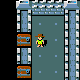

In [62]:
Image.fromarray(images_array[dataset_i,0,0,...])

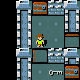

In [63]:
Image.fromarray(images_array[dataset_i,1,0,...])

In [64]:
preferences_binary[dataset_i]

1.0

In [79]:
unique_messages[-1][1:]

array([ 32,  45,  32,  97,  32, 107, 101, 121,  46,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [52]:
# img_dir = "/lustre/home/csancaktar/Projects/mydream_er/minihack4chris"

# pref = preferences_binary[dataset_i]
# key1 = inv_glyphs_binary[dataset_i,0,0,...].item()
# key2 = inv_glyphs_binary[dataset_i,1,0,...].item()

# # Image.fromarray(images_array[dataset_i,0,0,...]).save(os.path.join(img_dir, f"image_pair{global_i}_1_key{key1}_pref{pref+1}.png"))
# # Image.fromarray(images_array[dataset_i,1,0,...]).save(os.path.join(img_dir, f"image_pair{global_i}_2_key{key2}_pref{pref+1}.png"))


In [53]:
# inv_glyphs[dataset_i,0,0,...], inv_glyphs[dataset_i,1,0,...]

In [54]:
inv_glyphs_binary[dataset_i,0,0,...], inv_glyphs_binary[dataset_i,1,0,...]

(array([0], dtype=uint8), array([0], dtype=uint8))

In [56]:
for i in range(10):
    print("".join([chr(c) for c in inv_strings[dataset_i,1,0,i,:] if c >= 32]))

a +0 short sword (weapon in hand)
10 +0 daggers (alternate weapon; not wielded)
an uncursed +1 leather armor (being worn)
an uncursed potion of sickness
an uncursed lock pick
an empty uncursed sack






In [55]:
for i in range(10):
    print("".join([chr(c) for c in inv_strings[dataset_i,0,0,i,:] if c >= 32]))

a +0 short sword (weapon in hand)
8 +0 daggers (alternate weapon; not wielded)
an uncursed +1 leather armor (being worn)
an uncursed potion of sickness
an uncursed lock pick
an empty uncursed sack






In [66]:
glpyhs[dataset_i,0,0,...], glpyhs[dataset_i,1,0,...]

(array([[2359, 2362, 2361, 2361, 2363],
        [2359, 2360, 2378, 2378, 2360],
        [2359, 2374,  337, 2378, 2360],
        [2359, 2360, 2378, 2378, 2360],
        [2359, 2374, 2382, 2378, 2360]]),
 array([[2359, 2362, 2375, 2361, 2369],
        [2359, 2360, 2378, 2378, 2360],
        [2359, 2360,  337, 2378, 2372],
        [2359, 2370, 2373, 2361, 2369],
        [2359, 2360, 2378, 2102, 2374]]))

In [70]:
# messages.shape: (100000, 2, 1, 256)

# message_t = "".join(map(chr, obs["message"]))
obs_messages = messages.reshape(-1, 256)
obs_glyphs = glpyhs.reshape(-1, 5, 5)

unique_messages = []
unique_messages_decoded = []

obs_from_unique_messages = []
unique_indices = []

global_i = 0
for message, glyph in zip(obs_messages, obs_glyphs):
    message_decoded = "".join([chr(c) for c in message if c >= 32])
    if message_decoded not in unique_messages_decoded:
        unique_messages_decoded.append(message_decoded)
        #obs_from_unique_messages.append(glyph_mapper._glyph_to_rgb(glyph))
        unique_messages.append(message)
        unique_indices.append(global_i)
    global_i += 1
    if global_i % 10000 == 0:
        print(f"Gone through {global_i} samples!")

Gone through 10000 samples!
Gone through 20000 samples!
Gone through 30000 samples!
Gone through 40000 samples!
Gone through 50000 samples!
Gone through 60000 samples!
Gone through 70000 samples!
Gone through 80000 samples!
Gone through 90000 samples!
Gone through 100000 samples!
Gone through 110000 samples!
Gone through 120000 samples!
Gone through 130000 samples!
Gone through 140000 samples!
Gone through 150000 samples!
Gone through 160000 samples!
Gone through 170000 samples!
Gone through 180000 samples!
Gone through 190000 samples!
Gone through 200000 samples!


## Load motif and test here!

In [730]:
import smart_settings
from motif.reward_model import RewardModel
from motif.eval_utils import get_batch_dict_for_reward_model, reward_model_with_mb

In [731]:
# motif_model_dir = "/fast/csancaktar/sensei_oracle_motif/minihack_binary_preference_job0"

# motif_model_dir = "/fast/csancaktar/results/motif/\
# minihack_dummy_data/grid_minihack_inventory_64x64_new_19_fixed_staircase/working_directories/0"

# motif_model_dir = "/fast/csancaktar/results/motif/\
# minihack_dummy_data/grid_minihack_inventory_64x64_100k_gpt/working_directories/10"

motif_model_dir = "/fast/csancaktar/results/motif/\
minihack_dummy_data/grid_keychest_64x64_100k_gpt/working_directories/11"

model_cpt_id = 49
device = "cuda:0"

In [732]:
params = smart_settings.load(os.path.join(motif_model_dir, "settings.json"), make_immutable=False)
motif_reward_model = RewardModel(params["reward_model_params"]["model_params"], device=device)
motif_reward_model.load(
    os.path.join(motif_model_dir, f"checkpoint_{model_cpt_id}")
)

In [733]:
rollout_images = images_array[dataset_i,[0,1],0,...]

obs_vec = inv_glyphs_binary[dataset_i,[0,1],0,...]
rollout_images_left = None
batch_dict = get_batch_dict_for_reward_model(
    motif_reward_model, rollout_images, obs_vec
)
reward_dict = reward_model_with_mb(motif_reward_model, batch_dict)

# motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy().item()
motif_reward = reward_dict.rewards.squeeze().detach().cpu().numpy()
print(motif_reward)

[13.914739   -0.48833212]


In [718]:
test = inv_glyphs_binary[dataset_i,[0,1],0,...].copy()

In [719]:
test

array([[0],
       [1]], dtype=uint8)

In [515]:
dataset_i

32362